In [8]:
# load corpus dataset
import os
import pandas as pd
import matplotlib.pyplot as plt

from datasets import load_from_disk
from src.data.create_corpus_dataset import create_dataset, DatasetConfig, UtteranceType, DatasetSplitType
from src.data.dataset_splits import create_splits_from_corpus_dataset
from collections import defaultdict

from src.features.build_features import filter_queries_for_few_shot_setting, filter_passages_for_few_shot_setting

# load dataset
dataset_folder = "../../data/processed/with_context"
dataset_path = os.path.join(dataset_folder, "corpus_dataset_v2")

if not os.path.exists(dataset_path):
    # Beispiel zum Erstellen eines Datensatzes. Mögliche Optionen von DatasetConfig sind im DocString beschrieben.
    create_dataset(
        DatasetConfig(
            dataset_path=dataset_path,
            project_dir="../../",
            utterance_type=UtteranceType.User,
            eval_size=0.5,
            validation_test_ratio=0.5
        )
    )

# Beispiel zum Laden des Datensatzes + collate_function des DataLoaders um dynamisch ein Subset der negative passages zu laden.
corpus_dataset = load_from_disk(dataset_path)
# load split dataset
in_distribution_split = create_splits_from_corpus_dataset(corpus_dataset=corpus_dataset,
                                                          dataset_split_type=DatasetSplitType.InDistribution,
                                                          save_folder=dataset_folder,
                                                          dataset_save_name="dataset_in_distribution")

Dataset already exists at ../../data/processed/with_context/dataset_in_distribution. Loading it.


In [ ]:
[p for p in corpus_dataset["queries"] if "NZ.K4-1" in p["labels"]]

In [ ]:
# Processing Features
num_shots_queries = 1
num_shots_passages = 1

train_split = in_distribution_split["train"]
eval_split = in_distribution_split["validation"]
test_split = in_distribution_split["test"]

# few-shots queries
# train_split = filter_queries_for_few_shot_setting(train_split, num_shots_queries)
#
#
# # few_shots passages
# train_split = filter_passages_for_few_shot_setting(train_split, num_shots_passages)


# in_distribution_split["train"] = train_split
in_distribution_split


In [ ]:
# Count labels per scenario and split for queries
label_counts = defaultdict(lambda: defaultdict(lambda: defaultdict(int)))

for split in ["train", "validation", "test"]:
    for query in in_distribution_split[split]["queries"]:
        scenario = query["discussion_scenario"]
        for label in query["labels"]:
            label_counts[split][scenario][label] += 1

# Build dataframe
records = []
for split, split_dict in label_counts.items():
    for scenario, labels in split_dict.items():
        for label, count in labels.items():
            records.append({
                "scenario": scenario,
                "label": label,
                "split": split,
                "count": count
            })

df = pd.DataFrame(records)
df.to_csv("simple_split_label_num_queries_distribution.csv")
display(df)

# Plot stacked bar chart per scenario
scenarios = df["scenario"].unique()
for scenario in scenarios:
    df_scenario = df[df["scenario"] == scenario]
    pivot_df = df_scenario.pivot(index="label", columns="split", values="count").fillna(0).sort_values("test", ascending=False)
    display(pivot_df)
    pivot_df.to_csv(f"simple_split_queries_counts_per_label_and_split_{scenario}.csv")
    pivot_df.plot(kind="bar", stacked=True, color=["blue", "yellow", "red"], figsize=(12, 12))
    plt.title(f"Query  Label Distribution in {scenario} for splits")
    plt.ylabel("Query Count")
    plt.xlabel("Label")
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()


In [ ]:
def create_scenario_plots(df, output_dir="plots", show_all_ranks=True, dpi=300, x_label_interval=2):
    """
    Create one rank-frequency plot for each scenario showing all splits as grouped bar charts.

    Parameters:
    -----------
    df : pandas DataFrame
        DataFrame with columns: scenario, label, split, count
    output_dir : str
        Directory to save the plots
    show_all_ranks : bool
        If True, show all ranks; if False, limit to the split with the fewest labels
    dpi : int
        Resolution for the saved plots
    x_label_interval : int
        Show x-axis labels every nth rank (2=every second, 3=every third, etc.)

    Returns:
    --------
    filenames : list
        List of saved filenames
    """
    import pandas as pd
    import matplotlib.pyplot as plt
    import seaborn as sns
    import os
    import numpy as np

    # Create output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)

    # Set plotting style
    plt.style.use('seaborn-v0_8-whitegrid')
    sns.set_context("paper", font_scale=1.2)

    # Colors for splits
    split_colors = {
        'train': '#4CAF50',      # Green
        'validation': '#2196F3', # Blue
        'test': '#FF5722'        # Orange
    }

    # Get all scenarios
    scenarios = df['scenario'].unique()

    # List to store filenames
    filenames = []

    # Create one plot per scenario
    for scenario in scenarios:
        # Filter data for this scenario
        scenario_data = df[df['scenario'] == scenario].copy()

        # Process each split
        split_data = {}
        max_rank = 0

        for split in ['train', 'validation', 'test']:
            # Filter data for this split
            split_df = scenario_data[scenario_data['split'] == split].copy()

            # Skip if no data
            if split_df.empty:
                split_data[split] = pd.DataFrame(columns=['rank', 'count', 'label'])
                continue

            # Sort by count (descending) and add rank
            split_df = split_df.sort_values('count', ascending=False).reset_index(drop=True)
            split_df['rank'] = split_df.index + 1  # Ranks start at 1

            # Store the data
            split_data[split] = split_df

            # Track the maximum rank for x-axis limit
            max_rank = max(max_rank, len(split_df))

        # Determine how many ranks to show
        if not show_all_ranks:
            # Find the minimum number of ranks across all splits with data
            non_empty_splits = [len(data) for split, data in split_data.items()
                               if not data.empty]
            if non_empty_splits:  # Make sure we have at least one non-empty split
                max_rank = min(non_empty_splits)

        # Create figure
        fig, ax = plt.subplots(figsize=(10, 6), dpi=dpi)

        # Set width of bars
        bar_width = 0.25

        # Create positions for each rank - making sure we start at rank 1
        bar_positions = np.arange(max_rank)  # 0-based array

        # Create the grouped bar chart
        for i, split in enumerate(['train', 'validation', 'test']):
            if split_data[split].empty:
                continue

            # For each split, get the ranks to plot (limited to max_rank)
            split_ranks = split_data[split][split_data[split]['rank'] <= max_rank]

            if split_ranks.empty:
                continue

            # Calculate position for this split (adjusting for grouped bars)
            # -bar_width, 0, +bar_width for the three splits
            position_adjust = (i - 1) * bar_width

            # Plot this split's bars
            bars = ax.bar(
                bar_positions[:len(split_ranks)] + position_adjust + 1,  # +1 to shift to ranks starting at 1
                split_ranks['count'].values,
                width=bar_width,
                color=split_colors[split],
                label=f"{split.capitalize()}",
                alpha=0.8,
                edgecolor='black',
                linewidth=0.5
            )

            # Add the label text above each bar
            if max_rank <= 15:  # Only add labels if not too crowded
                for j, bar in enumerate(bars):
                    height = bar.get_height()
                    if j < len(split_ranks):  # Make sure we have data for this index
                        label_text = split_ranks['label'].iloc[j]
                        # Truncate long labels
                        if len(label_text) > 10:
                            label_text = label_text[:8] + '..'

                        # Don't show label for very small bars
                        if height > 0.05 * ax.get_ylim()[1]:
                            ax.text(
                                bar.get_x() + bar.get_width()/2,
                                height + 0.01 * ax.get_ylim()[1],
                                label_text,
                                ha='center',
                                va='bottom',
                                rotation=90,
                                fontsize=8
                            )

        # Set the x-axis ticks at the center of each group of bars
        tick_positions = np.arange(1, max_rank + 1)  # Ranks start at 1
        tick_labels = [f"{r}" if r % x_label_interval == 1 or r == 1 else ""
                      for r in range(1, max_rank + 1)]

        ax.set_xticks(tick_positions)
        ax.set_xticklabels(tick_labels)

        # Set labels and title
        ax.set_xlabel('Label Rank', fontsize=12)
        ax.set_ylabel('Number of Queries', fontsize=12)
        # ax.set_title(f'{scenario} - Rank-Frequency Distribution by Split', fontsize=14)

        # Add grid and clean up spines
        ax.grid(True, linestyle='--', alpha=0.7, axis='y')  # Only horizontal grid lines
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)

        # Add legend
        ax.legend(frameon=True, framealpha=0.9, loc='upper right')

        # Ensure y-axis starts at 0
        ax.set_ylim(bottom=0)

        # Set x-axis limits to ensure proper display of all bars including rank 1
        ax.set_xlim(0.5, max_rank + 0.5)

        # Add light background to alternate ranks for better readability
        # if max_rank > 1:
        #     for r in range(0, max_rank, 2):
        #         ax.axvspan(
        #             r + 0.5,  # Start at the left edge of the rank
        #             r + 1.5,  # End at the right edge of the rank
        #             color='gray',
        #             alpha=0.1
        #         )

        # Print debug info for first 5 ranks
        for split in ['train', 'validation', 'test']:
            if not split_data[split].empty and len(split_data[split]) > 0:
                first_ranks = split_data[split].head(5)
                print(f"DEBUG - {scenario} - {split} - First 5 ranks:")
                print(first_ranks[['rank', 'count', 'label']])

        # Save the plot in EPS format
        file_format = "eps"
        filename = os.path.join(output_dir, f"{scenario}_rank_frequency.{file_format}")
        plt.tight_layout()
        plt.savefig(filename, format=file_format)
        plt.close()

        filenames.append(filename)

    return filenames

create_scenario_plots(df, output_dir="../../reports/dataset_statistics/corpus_dataset_v2/in_distribution_split", show_all_ranks=True, dpi=300)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


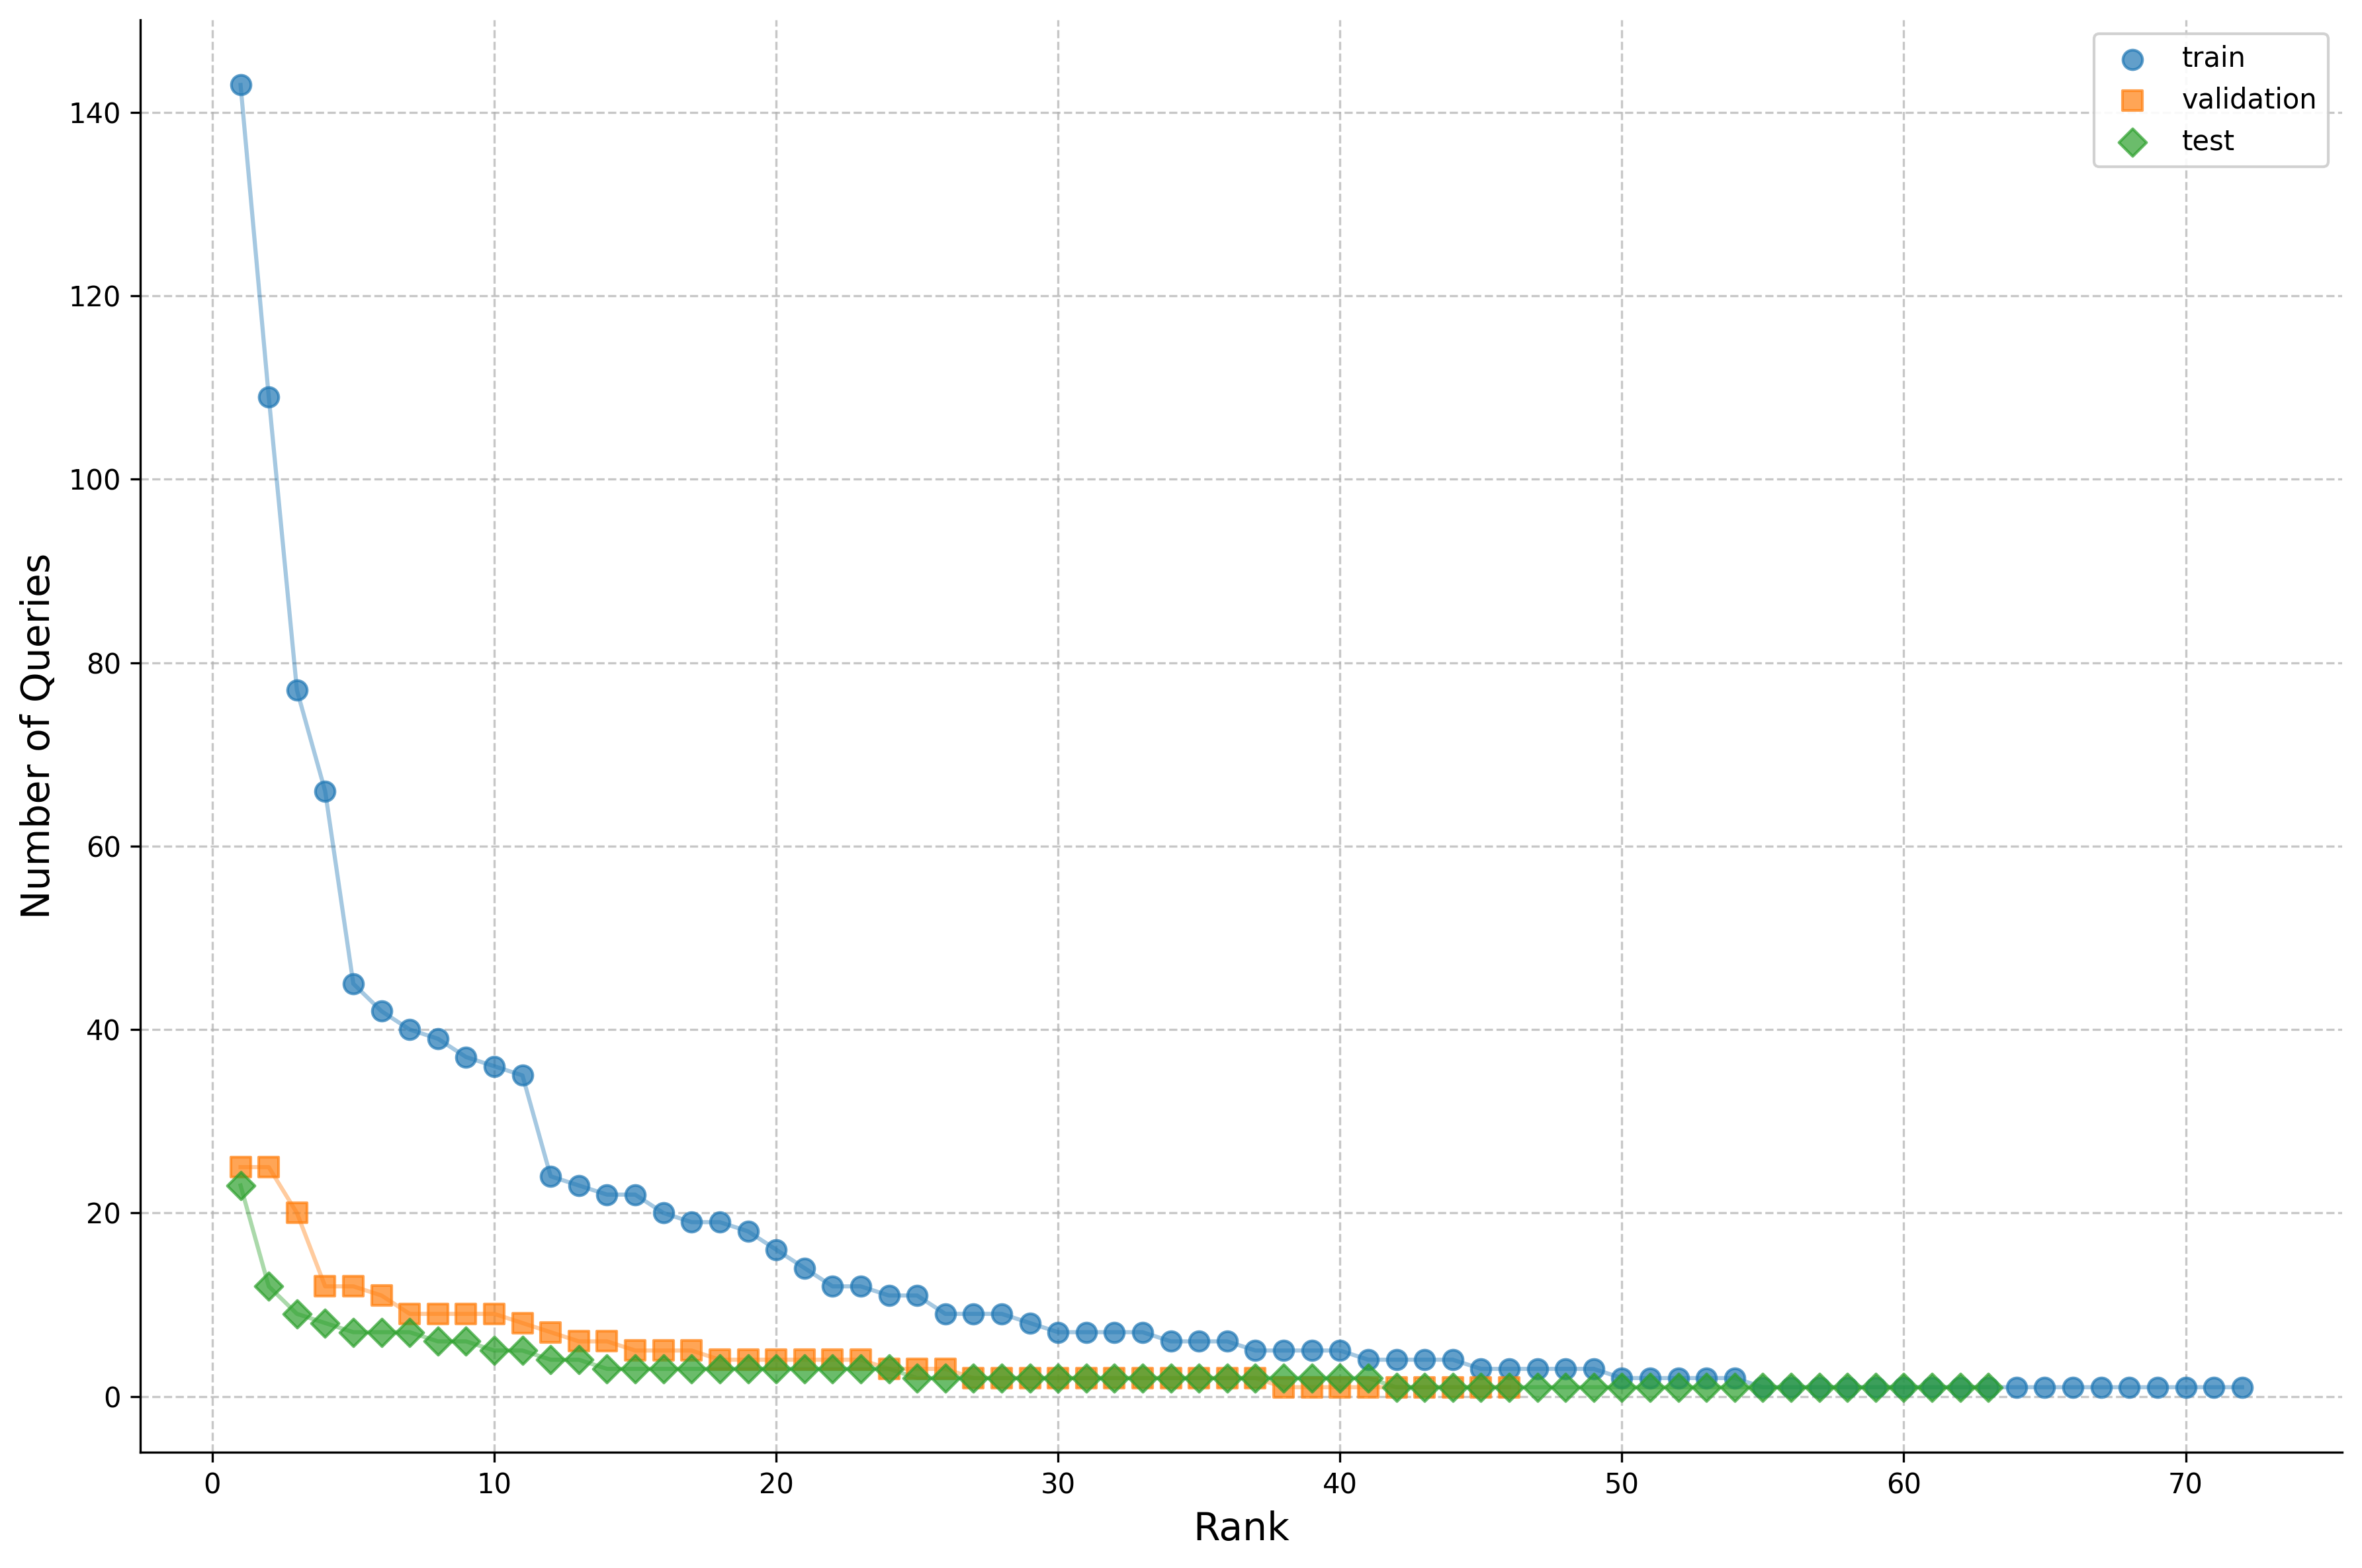

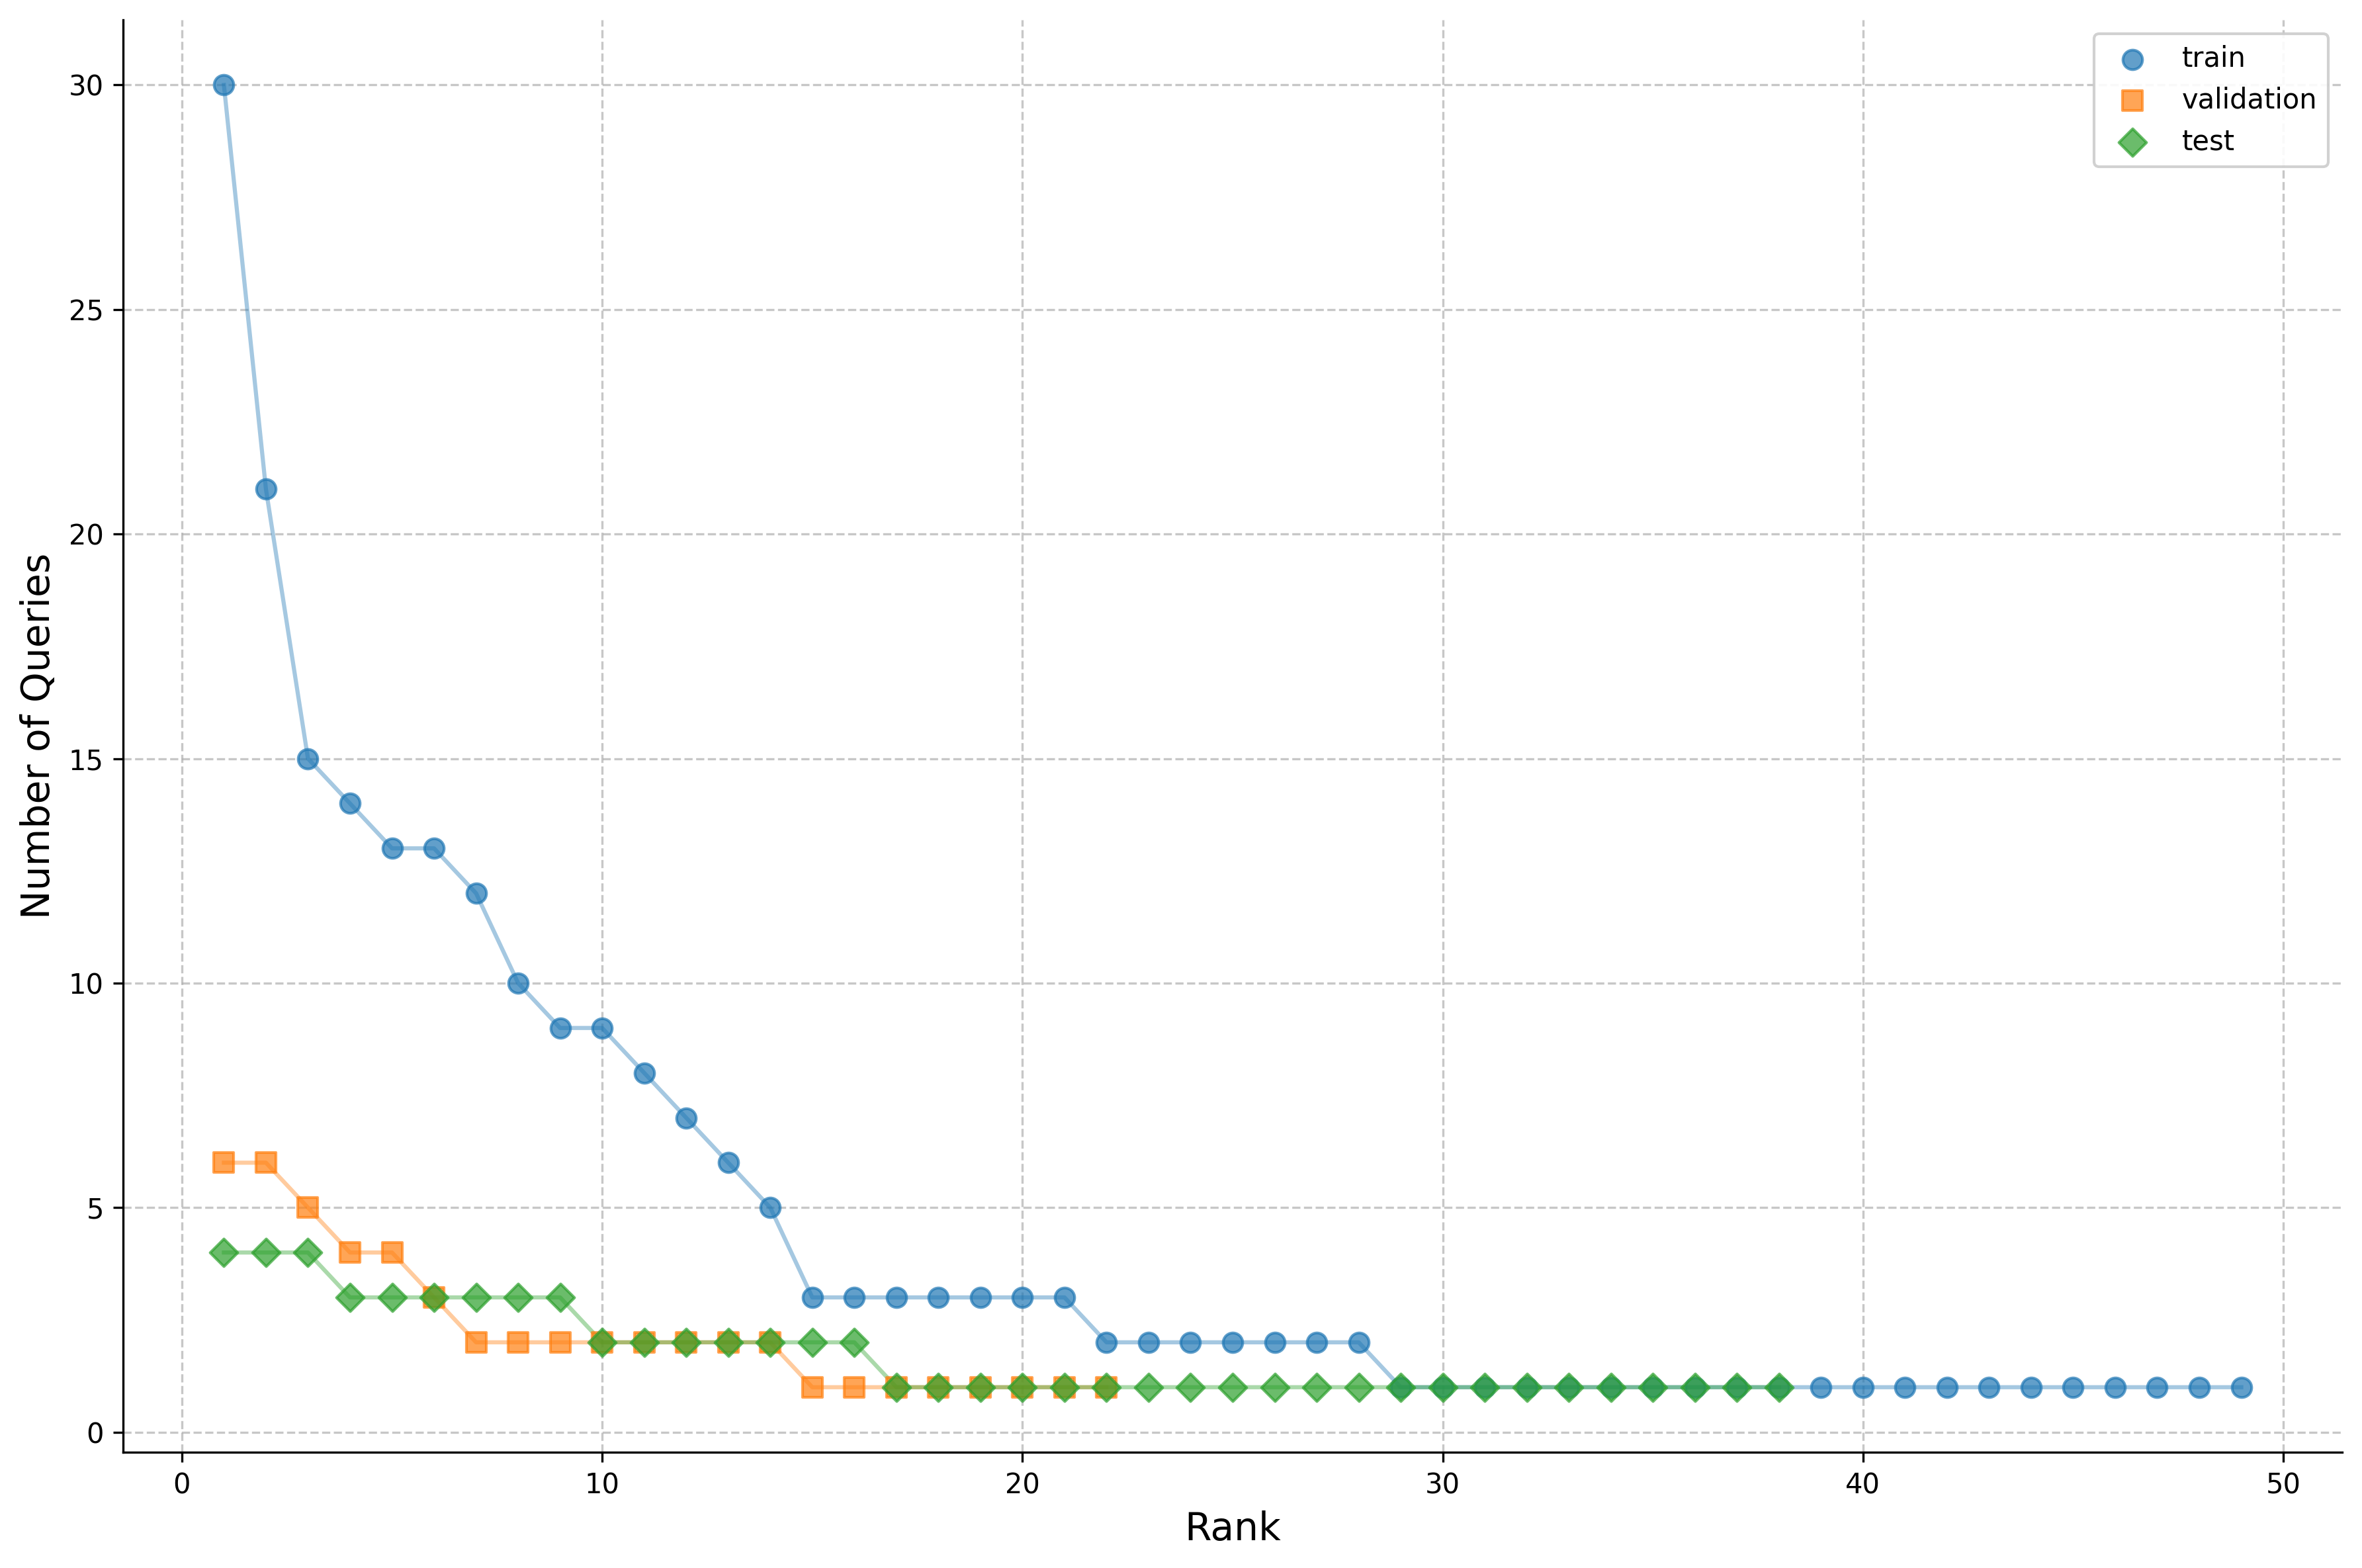

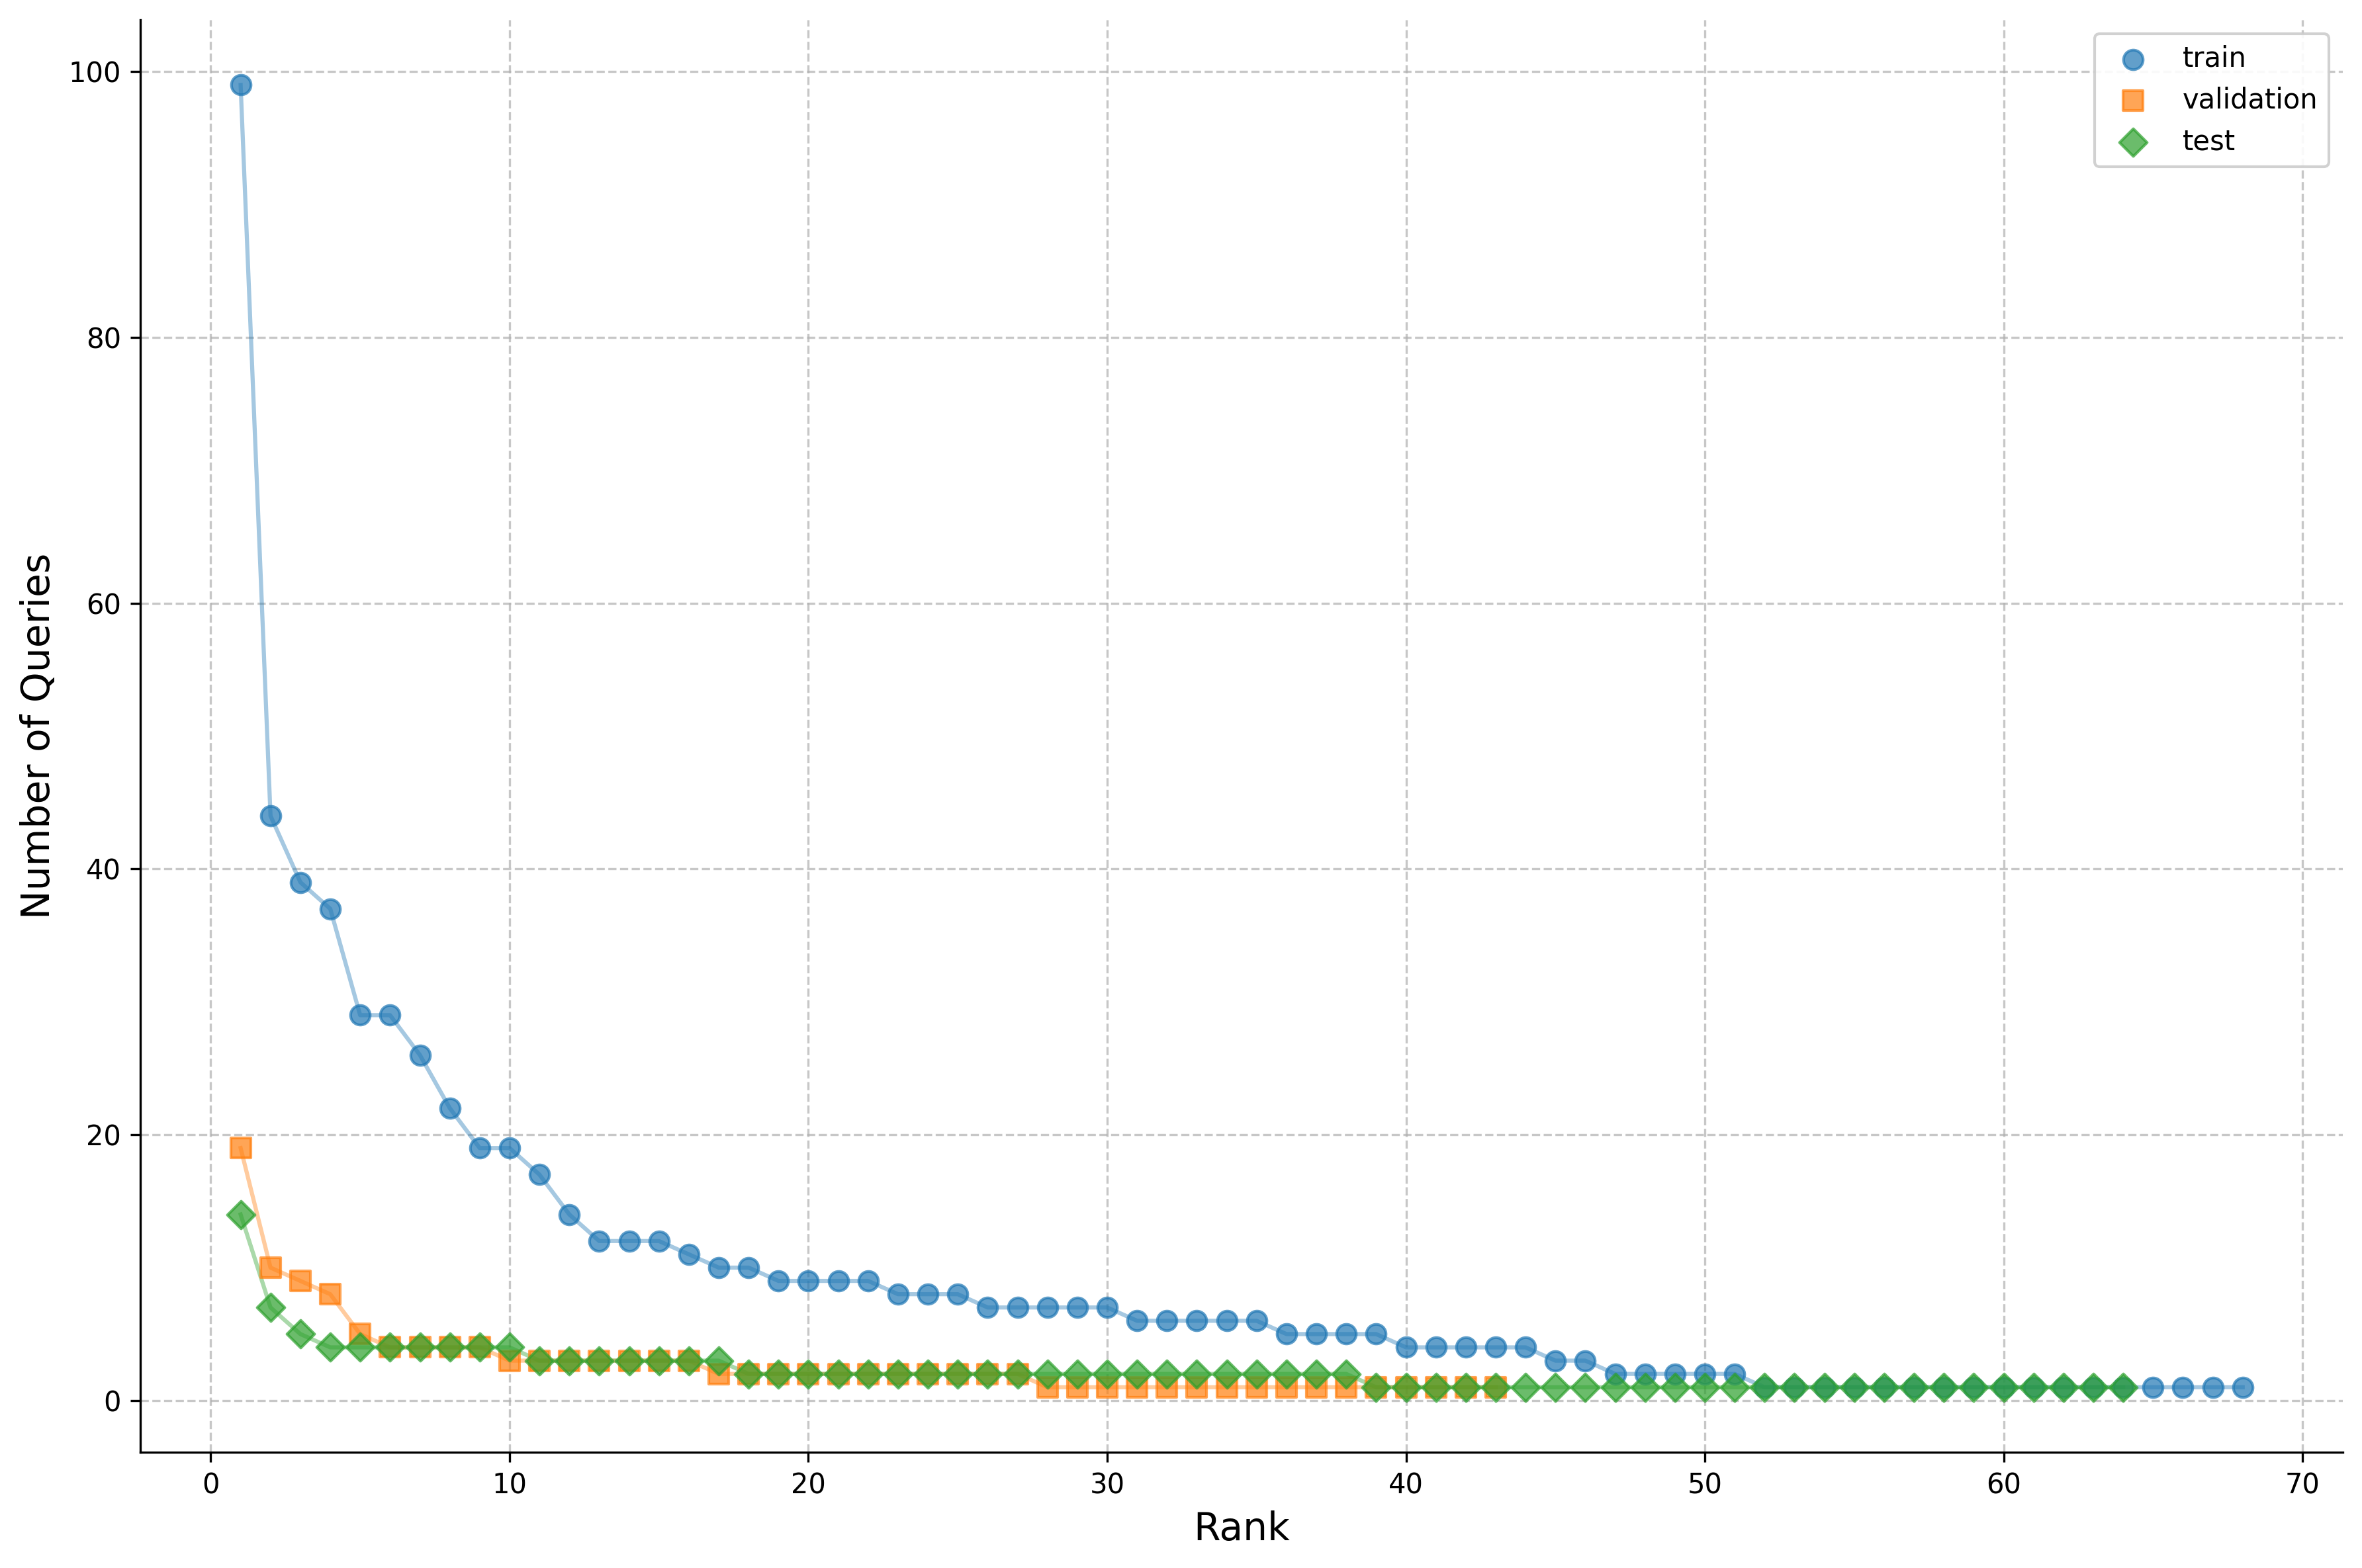

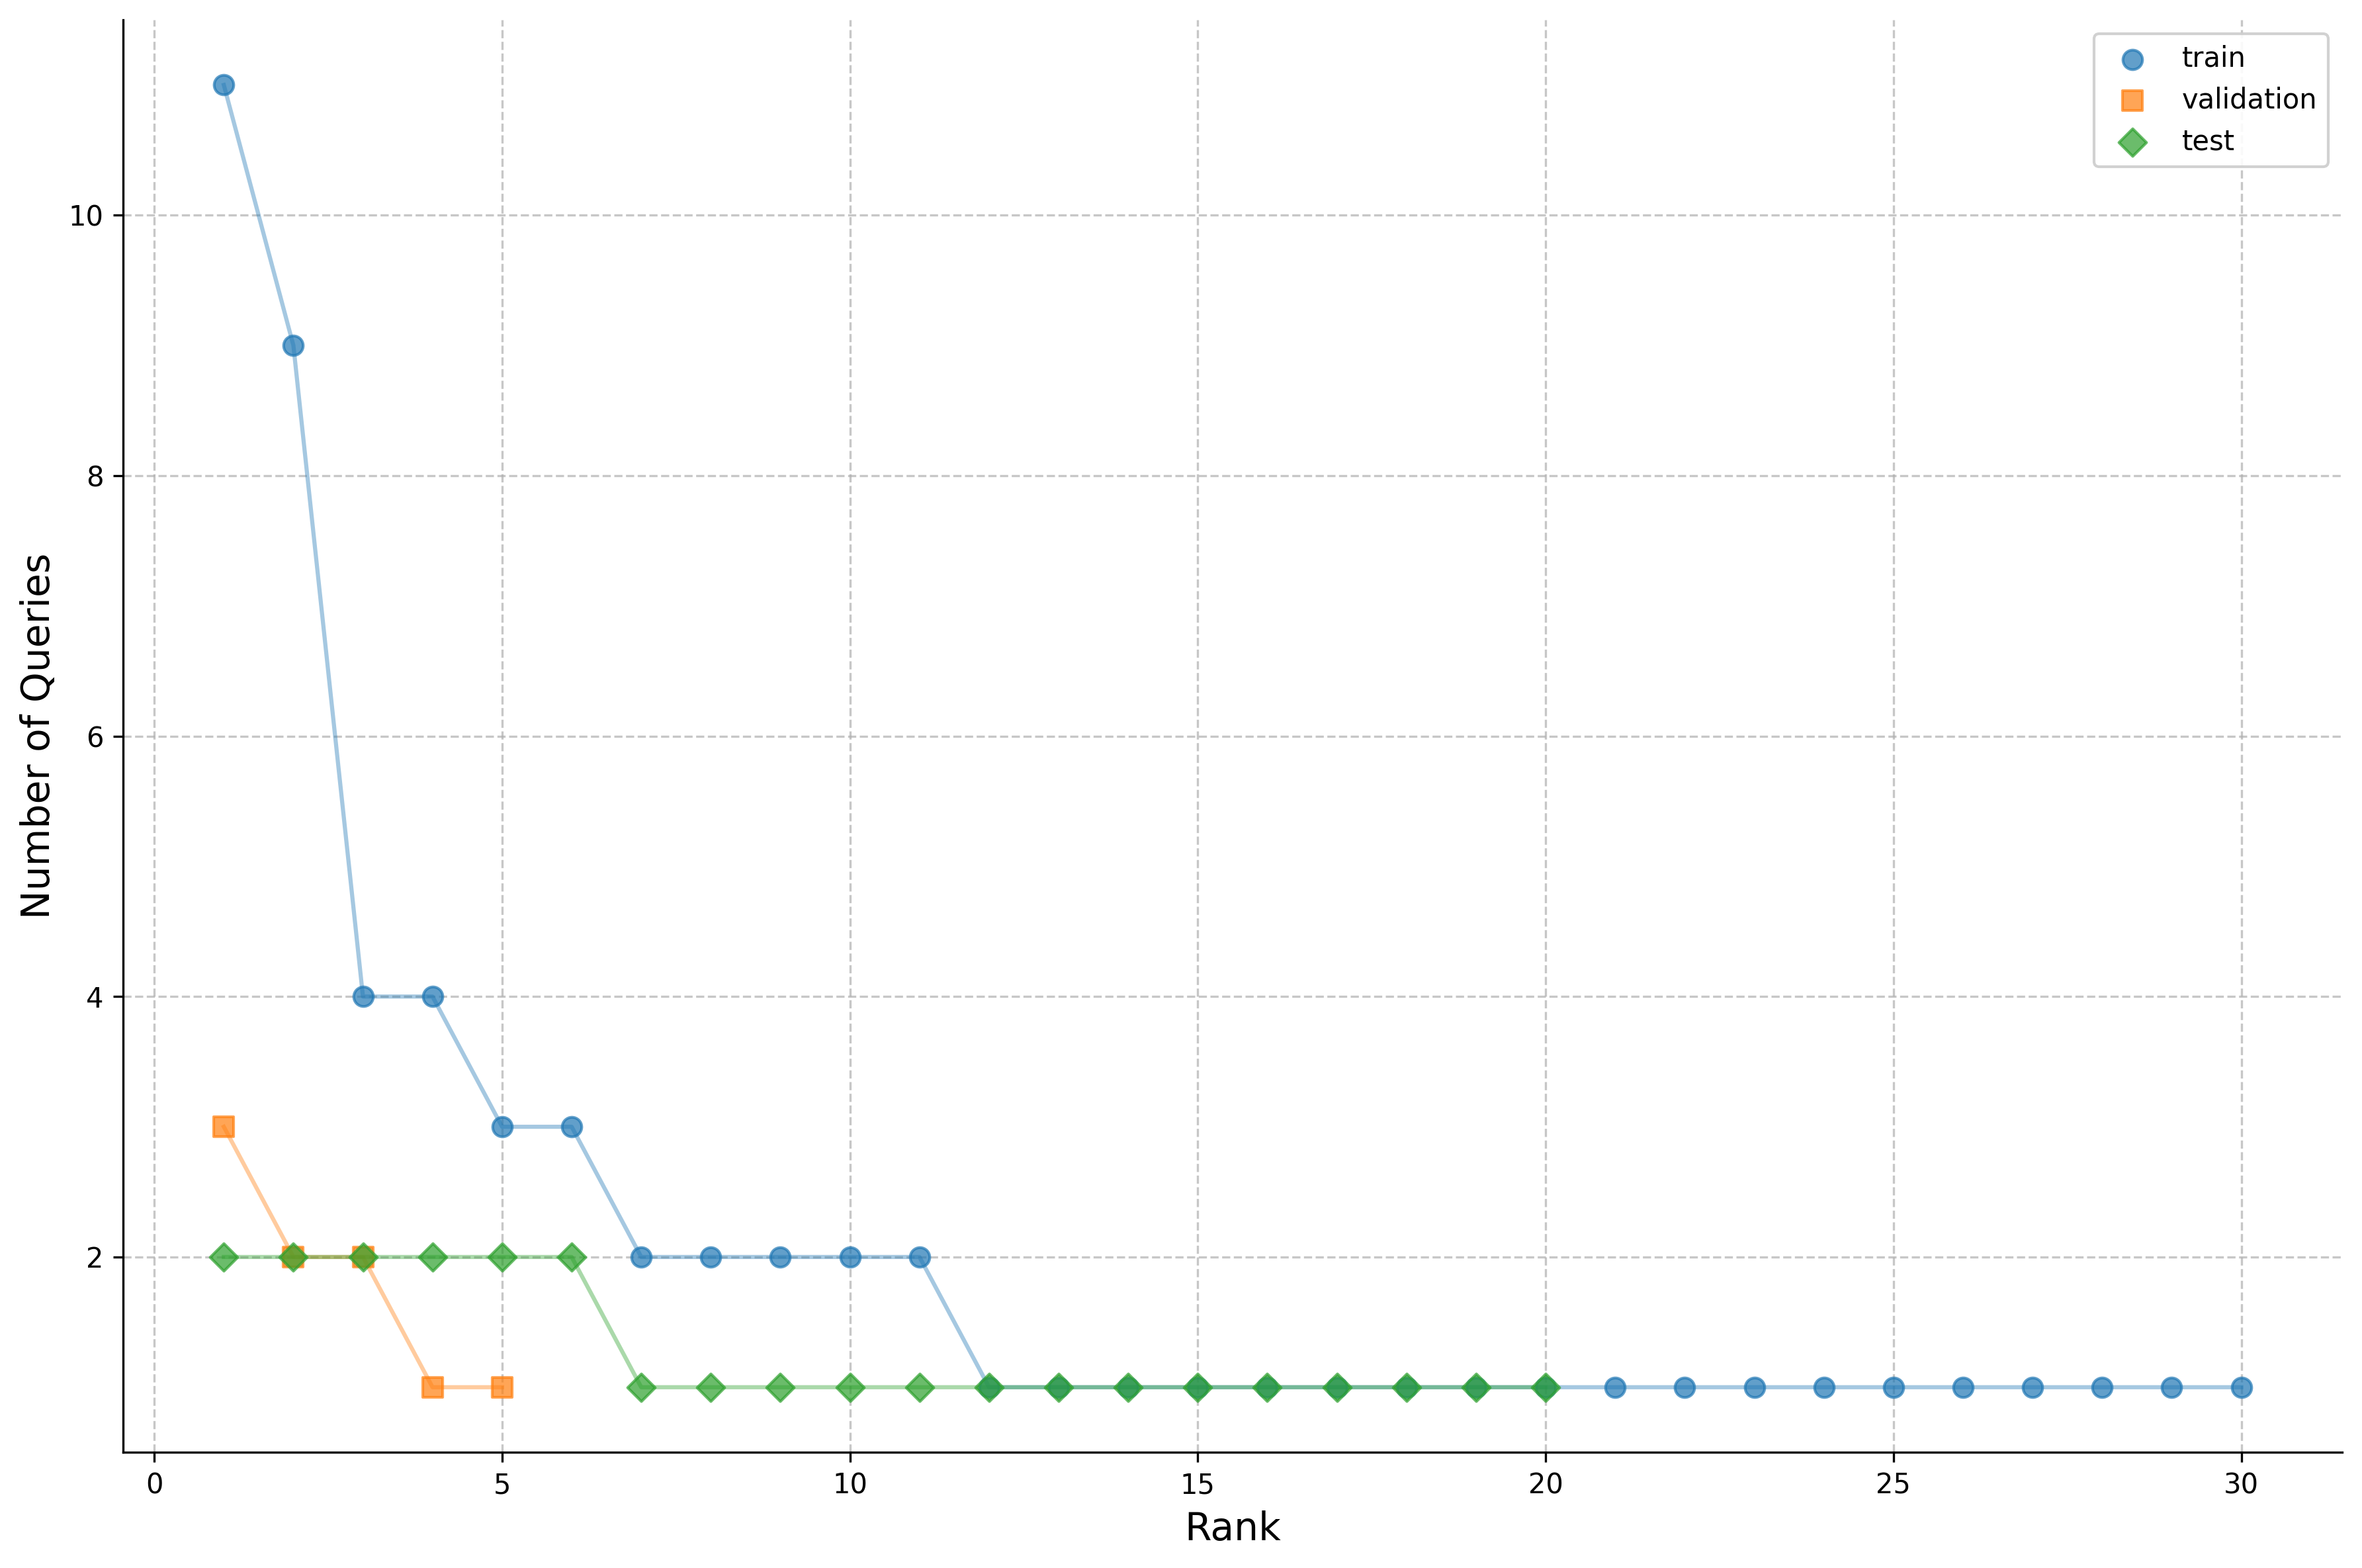

In [9]:
# Count labels per scenario and split for passages
label_counts = defaultdict(lambda: defaultdict(lambda: defaultdict(int)))

for split in ["train", "validation", "test"]:
    for passage in in_distribution_split[split]["passages"]:
        scenario = passage["discussion_scenario"]
        label_counts[split][scenario][passage["label"]] += 1

# Build dataframe
records = []
for split, split_dict in label_counts.items():
    for scenario, labels in split_dict.items():
        for label, count in labels.items():
            records.append({
                "scenario": scenario,
                "label": label,
                "split": split,
                "count": count
            })

df = pd.DataFrame(records)

# Plot stacked bar chart per scenario
scenarios = df["scenario"].unique()
for scenario in scenarios:
    df_scenario = df[df["scenario"] == scenario]
    pivot_df = df_scenario.pivot(index="label", columns="split", values="count").fillna(0).sort_values("test", ascending=False)
    display(pivot_df.tail())
    pivot_df.plot(kind="bar", stacked=True, color=["blue", "yellow", "red"], figsize=(12, 12))
    plt.title(f"Passage Label Distribution in {scenario} for splits")
    plt.ylabel("Passage Count")
    plt.xlabel("Label")
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()

In [ ]:
def check_label_distribution(df):
    """
    Checks that any (scenario, label) pair found in 'validation' or 'test'
    also exists in 'train'. If not, prints out the faulty scenario-label pairs.
    Otherwise, confirms that the distribution is valid.
    """
    # Get all (scenario, label) pairs that appear in train (count > 0)
    train_pairs = df[(df["split"] == "train") & (df["count"] > 0)][["scenario", "label"]]
    allowed_pairs = set(zip(train_pairs["scenario"], train_pairs["label"]))

    # Find all pairs in validation/test that have count > 0
    non_train = df[df["split"].isin(["validation", "test"]) & (df["count"] > 0)].copy()

    # Mark which of these are allowed
    non_train["is_allowed"] = non_train.apply(
        lambda row: (row["scenario"], row["label"]) in allowed_pairs, axis=1
    )

    # Collect the ones that are not allowed
    faulty = non_train[~non_train["is_allowed"]]

    if len(faulty) > 0:
        print("Found scenario/label pairs in test/validation that do not appear in train:")
        print(faulty[["scenario", "label", "split", "count"]])
    else:
        print("All scenario/label pairs in test and validation are valid (they appear in train).")

check_label_distribution(dataframe)


